#Focused Ultrasound (FUS) Neuromodulation Platform

###Authors: Ruixing Liang rliang7@jh.edu

This script was developed for system designed to
study Focused Ultrasound (FUS) neuromodulation of human ***In-Vitro*** neural cultures in multi-well Microelectrode Arrays (MEAs). If you found this useful for your research please cite our work as indicated in Github https://github.com/Rxliang/FUSNeuromod.

##Prepare Libraries

In [1]:
platform = 'colab' #@param ['colab', 'jupyter_notebook'] {allow-input: true}

In [2]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
from scipy import signal
import seaborn as sns
from scipy.signal import hilbert

##Connect to Server if in colab

In [3]:
if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


##Read From .csv or .mat file

In [5]:
file_type = 'csv' #@param ['csv', 'mat']

##Examine Data and retrieve related information

In [6]:
if file_type == 'csv':
  df = pd.read_csv("/content/drive/MyDrive/FUS/FSU001.csv") #Specify the directory to your recording
  print(df["StimEvent"].fillna(0).sum())
  print(df.head())
  # df.iloc[1, 0]
  sf = round(1/abs(df.iloc[0,0] - df.iloc[1,0]))
  dur_sec = np.size(df.iloc[:,0])/sf
  time = df.iloc[:,0].T
  MEA_channel_raw_read = np.asarray(df.iloc[:,1:17].T)

0.0
      Time  B6e_11  B6e_12  B6e_13  B6e_14  B6e_21  B6e_22  B6e_23  B6e_24  \
0  0.00000      10     -77      74     -92      -6     -51     -37     112   
1  0.00008      17    -115     119     -87     -53     -90     -44      93   
2  0.00016     -13    -131     137     -81     -52    -118      -4      62   
3  0.00024     -52    -112     121     -27     -32    -176      10      16   
4  0.00032     -47     -72      89      60      11    -179      20     -18   

   B6e_31  B6e_32  B6e_33  B6e_34  B6e_41  B6e_42  B6e_43  B6e_44  StimEvent  
0     -27       8     -76     -43      12      -8     -42     -27        NaN  
1      10     -61     -52     -16       0      32     -38     -25        NaN  
2      25    -102     -20      29      -9      45     -14     -24        NaN  
3      42     -80      -7      58     -23      58      15     -47        NaN  
4      44     -53       4      29     -34      87      48     -58        NaN  


In [7]:
# For Mat File
if file_type == 'mat':
  mat = io.loadmat("FSU003.mat") #Get data out from matlab file
  sf = round(1/abs(mat['FSU003'][0,0] - mat['FSU003'][1,0]))
  dur_sec = np.size(mat['FSU003'][:,0])/sf
  time = mat['FSU003'][:,0].T
  MEA_channel_raw_read = mat['FSU003'][:,1:17].T

##Preview of Data

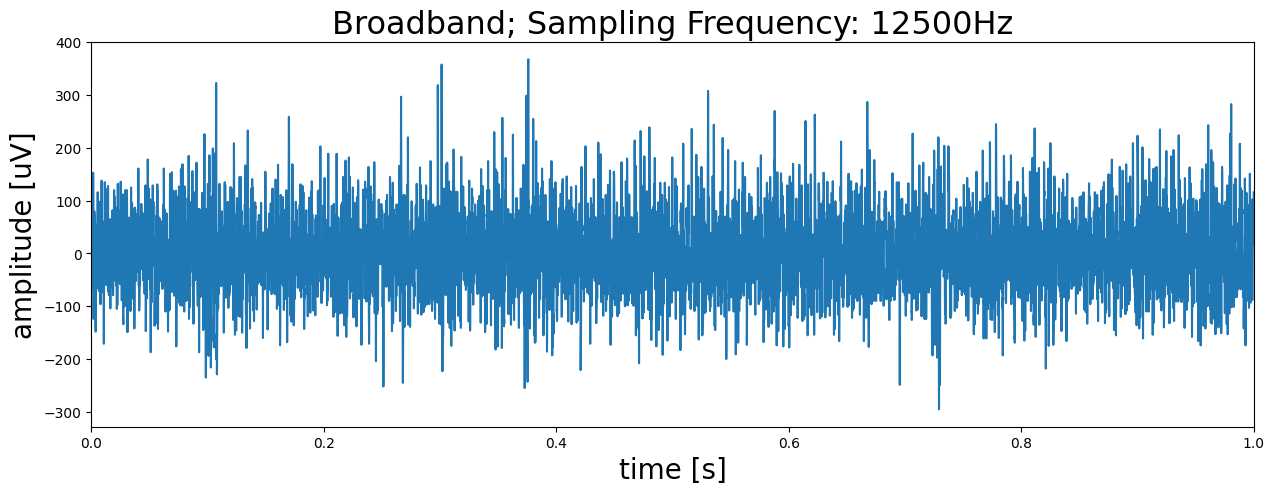

In [8]:
#Show one channel Data as a preview
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(time[0:sf], MEA_channel_raw_read[11,0:sf])
ax.set_title('Broadband; Sampling Frequency: {}Hz'.format(sf), fontsize=23)
ax.set_xlim(0, time[sf])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)
plt.show()

In [14]:
df = pd.DataFrame(MEA_channel_raw_read[:,100*sf:120*sf])

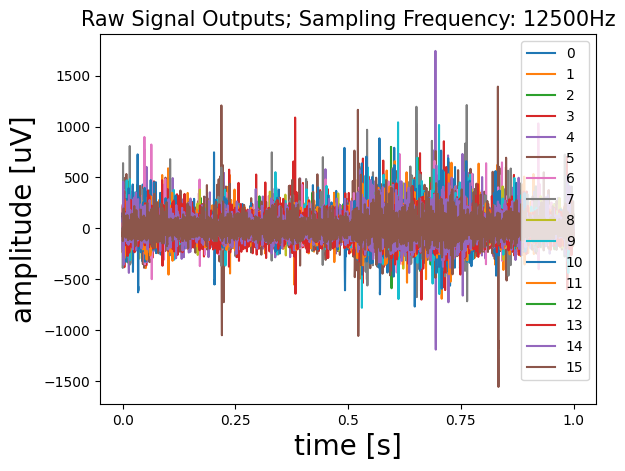

In [10]:
slice = df.iloc[:,:sf]
slice.T.plot()
plt.title('Raw Signal Outputs; Sampling Frequency: {}Hz'.format(sf), fontsize=15)
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('amplitude [uV]', fontsize=20)
plt.xticks(np.linspace(0,sf,5),labels = np.linspace(0,1,5))
plt.savefig('raw.png', dpi = 300,bbox_inches='tight')

##Processing Data

###Hyper Parameter Tune

In [11]:
Low_cut = 5 #@param [5, 20, 60, 100, 150, 200]
High_cut = 3000 #@param [3000, 4000, 5000, 6000, 7000, 8000]
sigma = 3 #@param [3,4,5,6]
threshold = 5 #@param [3,4,5,6]
window_length = 0.05 #@param [0.025,0.05,0.1,0.2]


###Bandpass Filter

In [16]:
from scipy import signal
b,a = signal.butter(8,[0.016,0.24],'bandpass')
filtered_signal = signal.filtfilt(b,a,df)
filtered_signal.shape

(16, 250000)

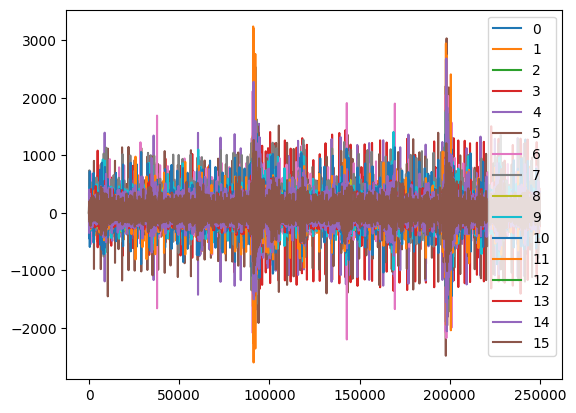

In [17]:
pd.DataFrame(filtered_signal.T).plot()
plt.show()

###Spike Detection

In [18]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=2000):

    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data)) *tf

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0]
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:min(i+spike_window*2,data.shape[0])]

            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) +i

                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]

                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, np.pad(tmp_waveform,[0,spike_window*2-len(tmp_waveform)],mode='constant').reshape(1, spike_window*2), axis=0)
    # print(spike_samp)

    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind.astype(int)]
    wave_form = wave_form[ind]

    return spike_samp, wave_form

In [19]:
from scipy import stats
start = 0
end = 1
spike_matrix = []
n_spikes = []
fire_rate_shape = []
fire_rate_max = []
fire_rate_kde = []
fire_rate_kde_max = []
#define bins
binsize = 0.005*sf #seconds
bins= np.arange(0, sf*2+binsize, binsize)

for channel in range(16):
    spike_samp, wave_form = get_spikes(filtered_signal[channel,sf*start:sf*end].ravel(), spike_window=100, tf=4, offset=10,max_thresh = 3000)
    n_spikes.append(len(spike_samp))
    firing_rate_histogram = np.histogram(spike_samp, bins=bins)
    firing_rate = firing_rate_histogram[0] #conversion to hertz
    # firing_rate_histogram = (firing_rate,firing_rate_histogram[1])
    analytic_signal = hilbert(firing_rate)
    fire_rate_shape.append(analytic_signal)
    kernel = stats.gaussian_kde(spike_samp)
    Z = np.reshape(kernel(spike_samp).T, spike_samp.shape)
    fire_rate_kde.append(Z)
    fire_rate_kde_max.append(Z.max())
    fire_rate_max.append(max(firing_rate))
    spike_matrix.append(spike_samp)

# print(n_spikes)


###Raster Plot

<ipython-input-20-3e9b9fcdb899>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spikes = ax.eventplot(np.asarray(spike_matrix),colors = colors)


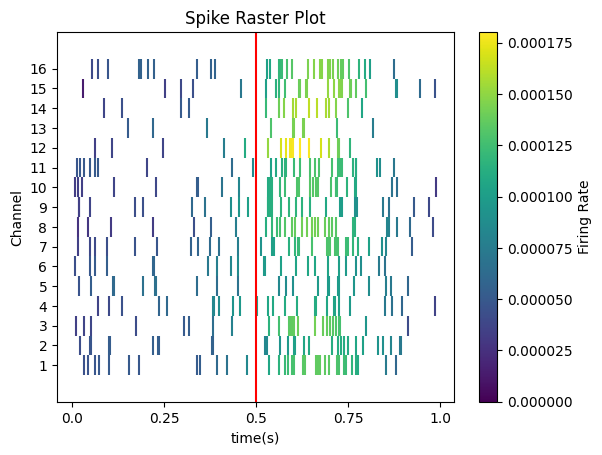

In [20]:
import matplotlib as mpl

norm = mpl.colors.Normalize(0, max(fire_rate_kde_max))
colors = [mpl.cm.viridis(norm(c)) for c in fire_rate_kde]


f, ax = plt.subplots()

spikes = ax.eventplot(np.asarray(spike_matrix),colors = colors)
spikes[0].set_norm(norm)
bar = f.colorbar(spikes[0])
# firing_y = np.linspace(0,52*20,6).astype(np.int)
# color_y = ['{}Hz'.format(y_label) for y_label in firing_y]
# bar.ax.set_yticklabels(color_y)
bar.set_label("Firing Rate")

ax.title.set_text('Spike Raster Plot')
# ax.title('Spike Raster Plot')
plt.xlabel("time(s)")
plt.ylabel("Channel")
plt.axvline(12500/2,color='r')
plt.xticks(np.linspace(0,sf,5),labels = np.linspace(start,end,5))
plt.yticks(list(range(0,16)),labels= list(range(1,17)))

plt.savefig('raster.png', dpi = 300,bbox_inches='tight')


<ipython-input-21-c4de32aa37e9>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(["","0 Hz","200 Hz","400 Hz"])
<ipython-input-21-c4de32aa37e9>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax1 = axs[1].eventplot(np.asarray(spike_matrix))


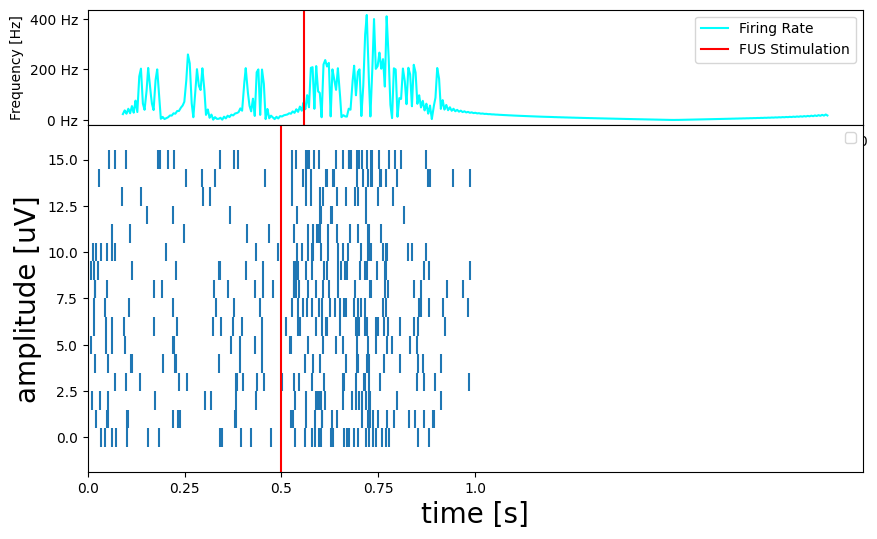

In [21]:
from scipy import interpolate

fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,3])
axs = gs.subplots(sharex=False, sharey=False)
x = firing_rate_histogram[1][:-1]
y = abs(analytic_signal)
f = interpolate.interp1d(x, y)
xnew = np.arange(0,24375)
ynew = f(xnew)
x_new = np.arange(0,2*sf)
y_new = np.hstack([ynew,np.zeros(2*sf-24375)])

ax0 = axs[0].plot(xnew, ynew,color = "cyan",label = "Firing Rate")
axs[0].set_yticklabels(["","0 Hz","200 Hz","400 Hz"])
ax1 = axs[1].eventplot(np.asarray(spike_matrix))
plt.xlim(0,2*sf)

ax3 = axs[0].axvline(12500/2,color='r',label = "FUS Stimulation")
axs[1].axvline(12500/2,color='r')
axs[0].legend()
axs[1].legend()
plt.xticks(np.linspace(0,sf,5),labels = np.linspace(start,end,5))
plt.xlabel('time [s]', fontsize=20)
axs[0].set_ylabel('Frequency [Hz]', fontsize=10)
axs[1].set_ylabel('amplitude [uV]', fontsize=20)
plt.savefig('raster_ver2.png', dpi = 300,bbox_inches='tight')

<ipython-input-22-213ab6a6998f>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.eventplot(np.asarray(spike_matrix))


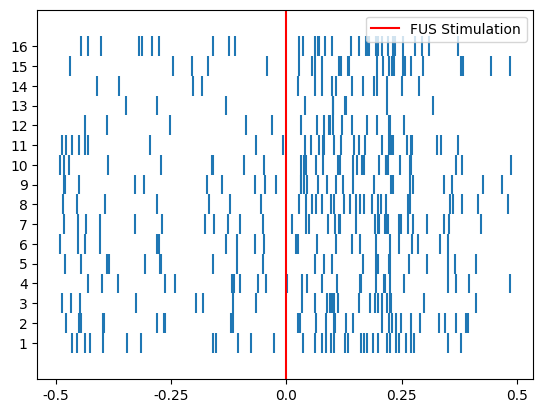

In [22]:
plt.eventplot(np.asarray(spike_matrix))
plt.xticks(np.linspace(0,sf,5),labels = np.linspace(-0.5,0.5,5))
plt.yticks(list(range(0,16)),labels= list(range(1,17)))
plt.axvline(12500/2,color='r',label = "FUS Stimulation")
plt.legend()
plt.savefig('raster.png', dpi = 300,bbox_inches='tight')


###Fire Rate Plot

In [23]:
spike_samp = np.unique(np.concatenate(spike_matrix).ravel())
np.save("new_data.npy",firing_rate)

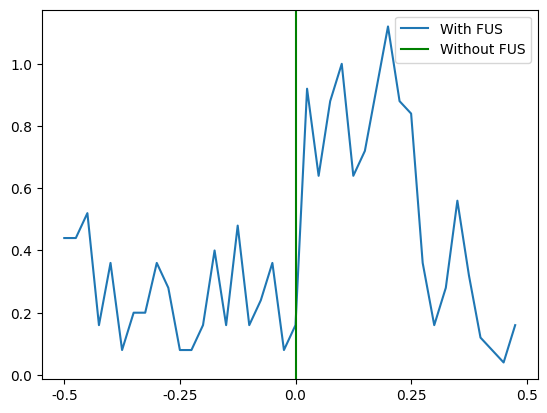

In [24]:
spike_samp = np.unique(np.concatenate(spike_matrix).ravel())
binsize = 0.025*sf #seconds
#
bins= np.arange(0, sf+binsize, binsize)

# sp_indicator = np.zeros(abs(sf*start-sf*end))
# sp_indicator[spike_samp.astype(np.int64).tolist()] = 1

# make a histogram

firing_rate_histogram = np.histogram(spike_samp, bins=bins)
firing_rate = firing_rate_histogram[0]*40/1000 #conversion to hertz
# firing_rate_histogram = (firing_rate,firing_rate_histogram[1])
# analytic_signal = hilbert(firing_rate)

# bins = int((sf*2+binsize) / binsize)+1

plt.plot(firing_rate_histogram[1][:-1],abs(firing_rate),label = "With FUS")
plt.xticks(np.linspace(0,sf,5),labels = np.linspace(-0.5,0.5,5))
plt.axvline(12500/2,color='g',label = "Without FUS")
legend = plt.legend()
# legend.get_lines()[0].set_color('blue')
# legend.get_lines()[0].set_color('blue')
# plt.xlabel('time [s]', fontsize=20)
# plt.show()
plt.savefig('FIRE.png', dpi = 300,bbox_inches='tight')

# sns.histplot(spike_samp,bins = bins,element="poly")

In [25]:
np.mean(firing_rate[20:]*1000)

540.0

In [26]:
firing_rate.shape

(40,)

#Supplementary Spike Sorting

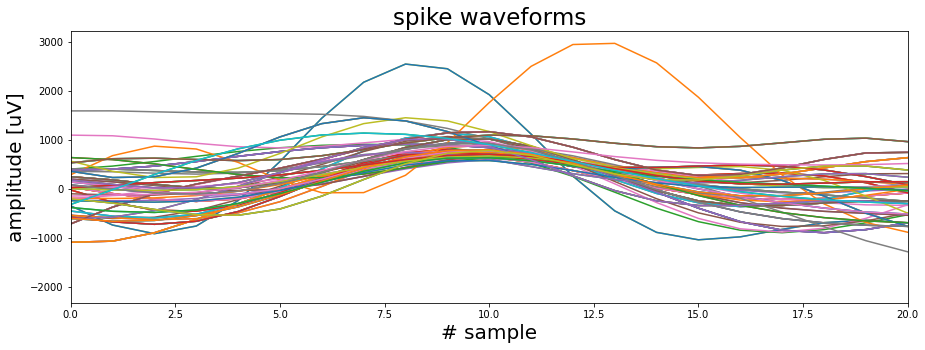

In [ ]:
start = 543
end = 545
spike_samp, wave_form = get_spikes(filtered_signal[11,start*sf:end*sf].ravel(), spike_window=30, tf=5, offset=20)

np.random.seed(10)
fig, ax = plt.subplots(figsize=(15, 5))

for i in range(100):
    spike = np.random.randint(0, wave_form.shape[0])
    ax.plot(wave_form[spike, :])

ax.set_xlim([0, 20])
ax.set_xlabel('# sample', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)
ax.set_title('spike waveforms', fontsize=23)
plt.show()

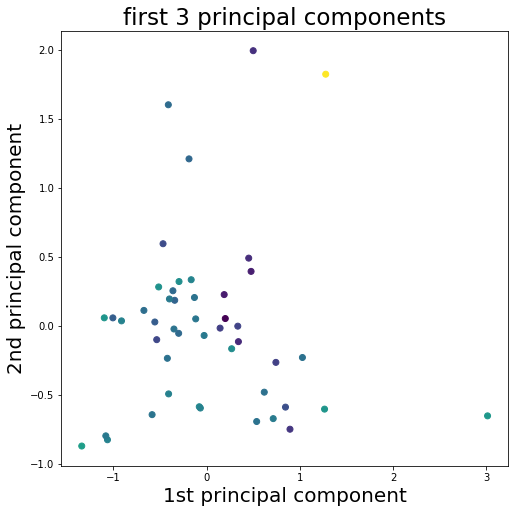

In [ ]:
import sklearn as sk
from sklearn.decomposition import PCA

# Apply min-max scaling
scaler= sk.preprocessing.MinMaxScaler()
dataset_scaled = scaler.fit_transform(wave_form)

# Do PCA
pca = PCA(n_components=15)
pca_result = pca.fit_transform(dataset_scaled)

# Plot the 1st principal component aginst the 2nd and use the 3rd for color
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2])
ax.set_xlabel('1st principal component', fontsize=20)
ax.set_ylabel('2nd principal component', fontsize=20)
ax.set_title('first 3 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

<ipython-input-21-e2c62c9ca6a8>:30: RuntimeWarning: Mean of empty slice.
  center_init.append(cluster_data[cluster == i, :].mean(axis=0).tolist())
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


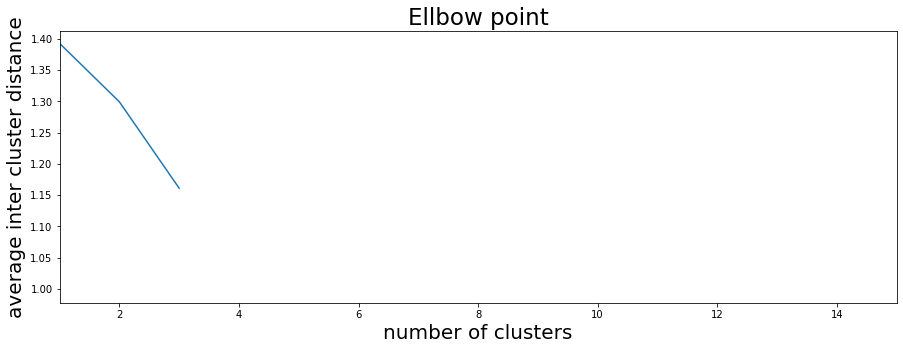

In [ ]:
def k_means(data, num_clus=3, steps=200):

    # Convert data to Numpy array
    cluster_data = np.array(data)

    # Initialize by randomly selecting points in the data
    center_init = np.random.randint(0, cluster_data.shape[0], num_clus)

    # Create a list with center coordinates
    center_init = cluster_data[center_init, :]

    # Repeat clustering  x times
    for _ in range(steps):

        # Calculate distance of each data point to cluster center
        distance = []
        for center in center_init:
            tmp_distance = np.sqrt(np.sum((cluster_data - center)**2, axis=1))

            # Adding smalle random noise to the data to avoid matching distances to centroids
            tmp_distance = tmp_distance + np.abs(np.random.randn(len(tmp_distance))*0.0001)
            distance.append(tmp_distance)

        # Assign each point to cluster based on minimum distance
        _, cluster = np.where(np.transpose(distance == np.min(distance, axis=0)))

        # Find center of mass for each cluster
        center_init = []
        for i in range(num_clus):
            center_init.append(cluster_data[cluster == i, :].mean(axis=0).tolist())

    return cluster, center_init, distance

max_num_clusters = 15

average_distance = []
for run in range(20):
    tmp_average_distance = []
    for num_clus in range(1, max_num_clusters +1):
        cluster, centers, distance = k_means(pca_result, num_clus)
        tmp_average_distance.append(np.mean([np.mean(distance[x][cluster==x]) for x in range(num_clus)], axis=0))
    average_distance.append(tmp_average_distance)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(range(1, max_num_clusters +1), np.mean(average_distance, axis=0))
ax.set_xlim([1, max_num_clusters])
ax.set_xlabel('number of clusters', fontsize=20)
ax.set_ylabel('average inter cluster distance', fontsize=20)
ax.set_title('Ellbow point', fontsize=23)
plt.show()


In [ ]:
from sklearn.manifold import TSNE
from numpy.random import RandomState
rng = RandomState(0)

t_sne = TSNE(
    n_components=3,
    perplexity=20,
    n_iter=250,
    init="random",
    random_state=rng,
)
S_t_sne = t_sne.fit_transform(dataset_scaled)
# X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=3).fit_transform(dataset_scaled)

In [ ]:
from matplotlib import ticker
from sklearn import manifold, datasets
%matplotlib inline

def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)

def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

S_points, S_color = datasets.make_s_curve(8189, random_state=rng)
plot_3d(S_t_sne, S_color, "T-distributed Stochastic  \n Neighbor Embedding")
plt.show()


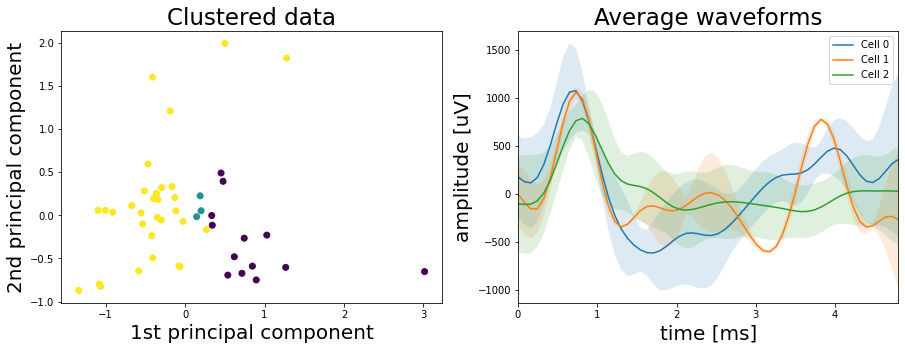

In [ ]:
num_clus = 3
cluster, centers, distance = k_means(pca_result, num_clus)

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster)
ax[0].set_xlabel('1st principal component', fontsize=20)
ax[0].set_ylabel('2nd principal component', fontsize=20)
ax[0].set_title('Clustered data', fontsize=23)

time = np.linspace(0, wave_form.shape[1]/sf, wave_form.shape[1])*1000
for i in range(num_clus):
    cluster_mean = wave_form[cluster==i, :].mean(axis=0)
    cluster_std = wave_form[cluster==i, :].std(axis=0)

    ax[1].plot(time, cluster_mean, label='Cell {}'.format(i))
    ax[1].fill_between(time, cluster_mean-cluster_std, cluster_mean+cluster_std, alpha=0.15)

ax[1].set_title('Average waveforms', fontsize=23)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=20)
ax[1].set_ylabel('amplitude [uV]', fontsize=20)

plt.legend()
plt.savefig('spikesort.png', dpi = 300)
plt.show()



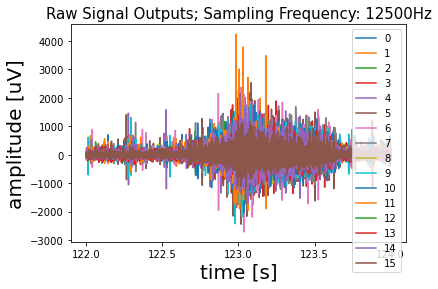

In [ ]:
start = 122
end = 124
slice = df.iloc[:,sf*start:sf*end]
slice.T.plot()
plt.title('Raw Signal Outputs; Sampling Frequency: {}Hz'.format(sf), fontsize=15)
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('amplitude [uV]', fontsize=20)
plt.xticks(np.linspace(sf*start,sf*end,5),labels = np.linspace(start,end,5))
plt.savefig('raw.png', dpi = 300,bbox_inches = 'tight')

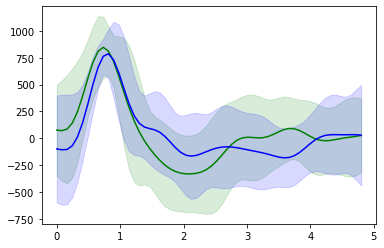

In [ ]:
i,j = 2,5
cluster_mean = mean_l[i]
cluster_std = std_l[i]
plt.plot(time, cluster_mean, label='Cell {}'.format(i),color = 'g')
plt.fill_between(time, cluster_mean-cluster_std, cluster_mean+cluster_std, alpha=0.15,color = 'g')
cluster_mean = mean_l[j]
cluster_std = std_l[j]
plt.plot(time, cluster_mean, label='Cell {}'.format(i),color = 'b')
plt.fill_between(time, cluster_mean-cluster_std, cluster_mean+cluster_std, alpha=0.15,color = 'b')
plt.savefig('spikecom.png', dpi = 300)
# plt.show()


In [ ]:
from scipy.signal import correlate
cor = correlate(mean_l[3],mean_l[5],mode = 'full')

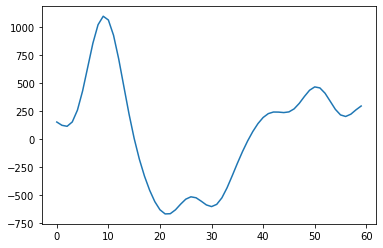

In [ ]:
plt.plot(mean_l[5])

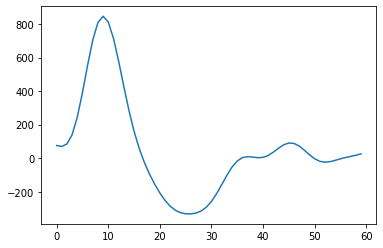

In [ ]:
plt.plot(mean_l[2])

##Processing

In [ ]:
sigma_n = np.median(abs(filtered_signal_slice)) / 0.6745
# print(sigma_n)
threshold = 5 * sigma_n
threshold

458.54450973457847

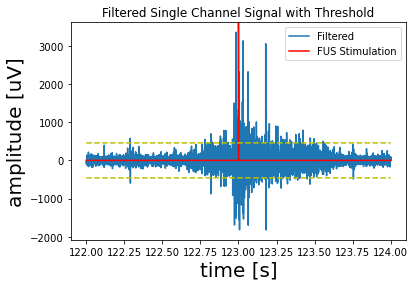

In [ ]:

filtered_signal_slice = signal.filtfilt(b,a,slice)

t = time[sf*start:sf*end]
def filtered_dataplot():
    plt.plot(t, filtered_signal_slice[11,:],label='Filtered')
    plt.title("Filtered Single Channel Signal with Threshold")
    plt.axis("tight")


st_ind = np.array([60+6 ,2*60+3, 3*60+13, 4*60+22, 5*60+38, 9*60+4, 10*60+5, 11*60+43, 12*60+16, 15*60, 16*60+14, 17*60+32])
st_ind = st_ind*sf

st_indicator = np.zeros(time.shape[0])
st_indicator[st_ind] = 4000
st_indicator_slice = st_indicator[sf*start:sf*end]

filtered_dataplot()
plt.plot(t,st_indicator_slice,c='r',label = "FUS Stimulation")
plt.plot(t, threshold * np.ones(len(t)), c="y", linestyle="--" )
plt.plot(t, -1*threshold * np.ones(len(t)), c="y", linestyle="--" )
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('amplitude [uV]', fontsize=20)
plt.legend()
plt.savefig('filtered.png', dpi = 300,bbox_inches='tight')



##Threshold

In [ ]:
tMax_hard = index[abs(single)>threshold]
tMax = np.array(list(set(signal.argrelmax(selected_filtered_single)[0]).intersection(set(tMax_hard))))
tMin_hard = index[single<-threshold]
tMin = np.array(list(set(signal.argrelmin(selected_filtered_single)[0]).intersection(set(tMin_hard))))

##Gaussian Filter

Text(0, 0.5, 'amplitude [uV]')

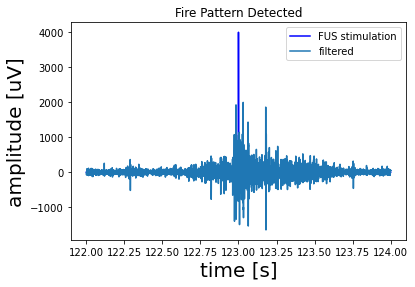

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d
selected_filtered_single = gaussian_filter1d(filtered_signal, sigma=3)
index = np.arange(len(single))

tMax_hard = index[abs(single)>threshold]#Hard Threshold
tMax = np.array(list(set(signal.argrelmax(selected_filtered_single)[0]).intersection(set(tMax_hard))))
tMin_hard = index[single<-threshold]#Hard Threshold
tMin = np.array(list(set(signal.argrelmin(selected_filtered_single)[0]).intersection(set(tMin_hard))))

# plt.plot(single, label = 'raw')
sp_indicator = np.zeros(time.shape[0])
# sp_indicator[spike_samp.astype(np.int64).tolist()] = 3000
# sp_indicator_slice = sp_indicator[sf*start:sf*end]

plt.title("Fire Pattern Detected")
plt.plot(t,st_indicator_slice,c='b',label = "FUS stimulation")

# plt.plot(t,sp_indicator_slice,c='y',label = "spike detected")

plt.plot(t,selected_filtered_single, label = 'filtered')
# plt.plot(tMax,selected_filtered_single[tMax], 'o', mfc= 'none', label = 'max')
# plt.plot(tMin,selected_filtered_single[tMin], 'o', mfc= 'none', label = 'min')
# plt.plot(t, threshold * np.ones(len(t)), c="r", linestyle="--" )
# plt.plot(t, -1*threshold * np.ones(len(t)), c="r", linestyle="--" )
# plt.xticks(np.linspace(sf*start,sf*end,5),labels = np.linspace(start,end,5))
plt.legend()
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('amplitude [uV]', fontsize=20)
# plt.savefig('filter_final.png', dpi = 300,bbox_inches='tight')

In [ ]:
import librosa
import librosa.display
single = filtered_signal_slice[11,:]
selected_filtered_single = gaussian_filter1d(single, sigma=3)

fig, ax = plt.subplots()
img = librosa.display.specshow(selected_filtered_single, ax=ax)
fig.colorbar(img, ax=ax)
plt.show()